In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from math import inf

In [98]:
# > 0 jeżeli a->b->c tworzy skręt w lewo
def orient(a, b, c):
    return (
        a[0]*b[1]
        + b[0]*c[1]
        + a[1]*c[0]
        - b[1]*c[0]
        - c[1]*a[0]
        - a[1]*b[0]
    )
    
def section_to_line(s):
    (x1, y1), (x2, y2) = s
    
    a = (y1 - y2)/(x1 - x2)
    b = y1 - x1 * a
    return a, b

# czy a jest po lewej od b (leksykograficznie)
def point_cmp(a, b):
    if a[0] < b[0] or (a[0] == b[0] and a[1] < b[1]):
        return 1
    elif a[0] == b[0] and a[1] == b[1]:
        return 0
    else: 
        return -1
# czy p znajduje sie nad section
def section_cmp(section, p):
    return orient(section[0], section[1], p)

In [122]:
class Trapezoid:
    def __init__(self, top, bottom, leftp, rightp):
        self.top = top
        self.bottom = bottom
        self.leftp = leftp
        self.rightp = rightp
    
    def as_verticies(self, sections):
        a, b = section_to_line(sections[self.top])
        c, d = section_to_line(sections[self.bottom])
        
        x1 = self.leftp[0]
        x2 = self.rightp[0]
        
        ll = (x1, c * x1 + d)
        lu = (x1, a * x1 + b)
        rl = (x2, c * x2 + d)
        ru = (x2, a * x2 + b)
        return [ll, rl, ru, lu]

class Node:
    def __init__(self):
        self.left = None
        self.right = None
    def follow(self, p, sections):
        return self.left

class TrapezoidNode(Node):
    # jeżeli ma jednego sasiada to jest lower
    def __init__(self, trapezoid, parent):
        self.trapezoid = trapezoid
        self.left_lower = None
        self.left_upper = None
        self.right_lower = None
        self.right_upper = None
        
        self.parent = parent
    def follow(self, p, cmp):
        return None

class XNode(Node):
    def __init__(self, x):
        self.x = x
        Node.__init__(self)
    def follow(self, p, sections):
        if point_cmp(p, self.x) > 0:
            return self.left
        else:
            return self.right
        
class YNode(Node):
    def __init__(self, edge):
        self.edge = edge
        Node.__init__(self)
    def follow(self, p, sections):
        if section_cmp(sections[self.edge], p) > 0:
            return self.left
        else:
            return self.right
        
# DAG + SearchStruct
# punkty sa trzymane bezposrednio, odcinki po indeksie
# Struktura wyszukiwań i mapa trapezów sa obecnie jedna struktura
class TrapezoidalMap:
    def __init__(self, boundingbox, sections):
        self.root = Node()
        self.root.left = TrapezoidNode(boundingbox, self.root)
        self.sections = sections
        
    def find(self, p):
        curr = self.root
        while True:
            nxt = curr.follow(p, self.sections)
            if nxt == None: break
            curr = nxt
        return curr

    def find_intersecting_section(self, sect):
        p = self.sections[sect][0]
        q = self.sections[sect][1]
        
        inter = [self.find(p)]
        # while q is to the right of current rightp
        while point_cmp(inter[-1].trapezoid.rightp, q) > 0:
            # if current rightp is above sect
            if section_cmp(self.sections[sect], inter[-1].trapezoid.rightp):
                inter.append(inter[-1].right_lower)
            else:
                inter.append(inter[-1].right_upper)
        return inter
        
        

{'top': 1, 'bottom': 0, 'leftp': (3.981070117828858, 6.169943983001737), 'rightp': (6.948039405060845, 5.721807996909407)}


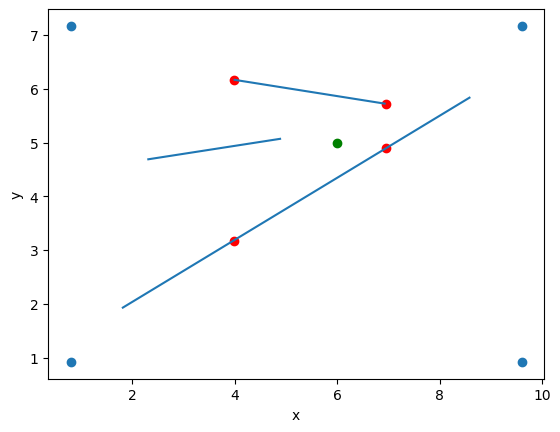

In [125]:
def get_bounding_box(sections, off=1):
    n = len(sections)
    
    minx = miny = inf
    maxx = maxy = -inf
    for sect in sections:
        for pt in sect:
            if pt[0] < minx:
                minx = pt[0]
            if pt[0] > maxx:
                maxx = pt[0]
            
            if pt[1] < miny:
                miny = pt[1]
            if pt[1] > maxy:
                maxy = pt[1]

    mx = (maxx + off, maxy + off)
    mn = (minx - off, miny - off)
    
    top = [(mn[0], mx[1]), mx]
    bot = [mn, (mx[0], mn[1])]
    
    sections.append(top)
    sections.append(bot)
    
    return Trapezoid(n, n + 1, mn, mx)

# TODO: przesunac prawdopodobnie do structa, poprawic kod zeby nie byl tak okropny
# TODO: zrobic zeby dzialalo dla wielu intersecting
def intersecting_one(trapezoidal_map, intersecting, i, sections):
    intersecting_trapezoid = intersecting.trapezoid
    p, q = sections[i]
        
    # tworzenie nowego poddrzewa w strukturze
    if intersecting == intersecting.parent.left:
        sub = intersecting.parent.left = XNode(p)
    else:
        sub = intersecting.parent.right = XNode(p)
    
    sub.right = XNode(q)
    sub.right.left = YNode(i)
    
    # tworzenie liści
    a = TrapezoidNode(Trapezoid(
        intersecting_trapezoid.top,
        intersecting_trapezoid.bottom,
        intersecting_trapezoid.leftp,
        p
    ), sub)
    sub.left = a
    
    c = TrapezoidNode(Trapezoid(
        intersecting_trapezoid.top,
        i,
        p,
        q
    ), sub.right.left)
    sub.right.left.left = c
    
    d = TrapezoidNode(Trapezoid(
        i,
        intersecting_trapezoid.bottom,
        p,
        q
    ), sub.right.left)
    sub.right.left.right = d
    
    b = TrapezoidNode(Trapezoid(
        intersecting_trapezoid.top,
        intersecting_trapezoid.bottom,
        q,
        intersecting_trapezoid.rightp,
    ), sub.right)
    sub.right.right = b
    
    # poprawianie sasiadow
    a.left_lower = intersecting.left_lower
    a.left_upper = intersecting.left_upper
    a.right_lower = d
    a.right_upper = c
    
    c.left_lower = a
    c.right_lower = b
    
    d.left_lower = a
    d.right_lower = b
    
    b.left_lower = d
    b.left_upper = c
    b.right_lower = intersecting.right_lower
    b.right_upper = intersecting.right_upper

    del intersecting

# UWAGA PRZYJMUJE ZE KONCE ODCINKOW SA PODANE ROSNACO WZGLEDEM X
def build_location_struct(sections, seed=0):
    # TODO: losowe permutacje sections
    n = len(sections)
    
    vis = Visualizer()
    vis.add_line_segment(sections)
    
    bounding_box = get_bounding_box(sections)
    
    vis.add_point(bounding_box.as_verticies(sections))
    
    trapezoidal_map = TrapezoidalMap(bounding_box, sections)
    
    intersecting = trapezoidal_map.find_intersecting_section(0)
    print(intersecting)
    intersecting_one(trapezoidal_map, intersecting[0], 0, sections)
    
    intersecting = trapezoidal_map.find_intersecting_section(1)
    print(intersecting)
    intersecting_one(trapezoidal_map, intersecting[0], 1, sections)
    # 1. Find trapezoids intersected by sections[i]
    # 2. Remove said trapezoids from the struct and add the newly created trapezoids 
        
    
    return trapezoidal_map, vis

# DEBUG:
sections = [
    ((1.8022020475178673, 1.9203785976434227), (8.601506664091172, 5.845431717210738)),
    ((3.981070117828858, 6.169943983001737), (6.948039405060845, 5.721807996909407)),
    ((2.2966969287231986, 4.686459339385744), (4.908248020088854, 5.07278346532741))
]
p = (6, 5)
result, vis = build_location_struct(sections)
found_trap = result.find(p).trapezoid
print(found_trap.__dict__)
vis.add_point(p, color="green")
vis.add_point(found_trap.as_verticies(sections), color="red")
vis.show()
